In [96]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords

import string
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from plotly import tools
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

#Import packages required for Models
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
import xgboost as xgb

import boto3


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Download and process the data from S3

In [2]:
s3_client = boto3.client('s3')

s3_client.download_file(
    Bucket='mlops-zc-sd-dev-dataset', 
    Key='raw/Sarcasm_Headlines_Dataset_v2.json', 
    Filename='../data/raw/Sarcasm_Headlines_Dataset_v2.json'
)

## Read the raw data

In [3]:
# Read in the data
df = pd.read_json("../data/raw/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...

In [4]:
df.columns
df.shape

(28619, 3)

In [5]:
print(df['is_sarcastic'].value_counts())

0    14985
1    13634
Name: is_sarcastic, dtype: int64


## Exploratory Data Analysis

Let's explore the data a bit.

### Sarcastic vs Non-sarcastic articles

In [11]:
labels = ['Sarcasm', 'Not Sarcasm']
values = [df['is_sarcastic'].sum(), len(df) - df['is_sarcastic'].sum()]

trace0 = go.Bar(x=[labels[1]], y=[values[1]], name='No Sarcasm')
trace1 = go.Bar(x=[labels[0]], y=[values[0]], marker={'color': '#00cc66'}, name='Sarcasm')

data = [trace0, trace1]

layout = go.Layout(title='Number of Sarcastic Articles',
                   width=800,
                   height=500,
                   yaxis=dict(title='Number of articles'))

fig = go.Figure(data, layout)

# Ensure the correct renderer is set
pio.renderers.default = 'notebook'

# Display the plot
fig.show()

### Data Cleaning

In [12]:
#Function to remove non ascii characters

def rem_non_ascii(data):
  stripped = (c for c in data if 0 < ord(c) < 127) 
  return ''.join(stripped)

In [13]:
#Lemmatisation
lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:          
    return None
  
def lemmatize_sentence(text):
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
  wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
  res_words = []
  for word, tag in wn_tagged:
    if tag is None:            
      res_words.append(word)
    else:
      res_words.append(lemmatizer.lemmatize(word, tag))
  return " ".join(res_words)

In [14]:
df.headline[1]

'dem rep. totally nails why congress is falling short on gender, racial equality'

In [15]:
#counting unwanted words
import re
count_url_re = 0
count_punc_re = 0
count_num_re = 0
count_mention_re = 0
count_aplha_num_re = 0

#df2= df.lower() 
for i in range(len(df.headline)):
  no_url_re = re.findall('https?://(www.)?\w+\.\w+(/\w+)*/?',df.headline[i])
  count_url_re += len(no_url_re)
  punc_re = re.findall('[%s]',df.headline[i]) 
  count_punc_re += len(punc_re)
  num_re = re.findall('(\\d+)', df.headline[i])
  count_num_re += len(num_re)
  mention_re = re.findall('@(\w+)', df.headline[i])
  count_mention_re += len(mention_re)
  alpha_num_re = re.findall("^[a-z0-9_.]+$", df.headline[i])
  count_aplha_num_re += len(alpha_num_re)

print ("Count of url in headline:", count_url_re)
print ("Count of punctuation in headline:",count_punc_re)
print ("Count of numbers in headline:",count_num_re)
print ("Count of mentions in headline:",count_mention_re)
print ("Count of alphanum in headline:",count_aplha_num_re)

Count of url in headline: 0
Count of punctuation in headline: 107328
Count of numbers in headline: 4980
Count of mentions in headline: 1
Count of alphanum in headline: 0


In [16]:
#Definition to remove punctuation 
def remove_features(data_str): # compile regex
    punc_re = re.compile('[%s]' % re.escape(string.punctuation)) 
    num_re = re.compile('(\\d+)')
    #mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    #data_str = url_re.sub(' ', data_str)
    # remove @mentions
    #data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters 
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word 
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word 
            else:
                cleaned_str += ' '
        list_pos += 1
    
    return " ".join(cleaned_str.split())

In [17]:
# Removing stop words


def remove_stops(data_str):
    # expects a string
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
            # rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

In [20]:
#Applying functions for cleaning data in the headline column of dataset

data = []
for i in range(len(df.headline)):
  res = remove_features(df.headline[i])
  res1 = rem_non_ascii(res)
  res2 = remove_stops(res1)
  res3 = lemmatize_sentence(res2)
  data.append(res3)
  

In [21]:
data

['thirtysomething scientist unveil doomsday clock hair loss',
 'dem rep totally nails congress fall short gender racial equality',
 'eat veggie deliciously different recipe',
 'inclement weather prevents liar get work',
 'mother come pretty close use word stream correctly',
 'white inheritance',
 'way file tax less stress',
 'richard branson global warm donation nearly much cost fail balloon trip',
 'shadow government get large meet marriott conference room',
 'lot parent know scenario',
 'lesbian consider father indiana amaze one',
 'amanda peet tell daughter sex special hug',
 'know regard current treatment ebola',
 'chris christie suggest hillary clinton blame boko haram kidnapping hundred schoolgirls',
 'ford develop new suv run purely gasoline',
 'uber ceo travis kalanick step trump economic advisory council',
 'area boy enters jump touch top doorway phase',
 'area man travel gurney',
 'leave person disability behind',
 'lin manuel miranda would like remind put phone away',
 'jour

### Adding the Clean headline data as a new column to Dataset

In [22]:
df['clean_headline'] = data

In [23]:
allWords_df = df['clean_headline'].str.split(expand = True).unstack().value_counts()
allWords_df = pd.DataFrame(allWords_df).reset_index()

In [24]:
trace0 = go.Bar(x = allWords_df['index'][0:50] , y = allWords_df[0][0:50], marker = dict(color = allWords_df[0]
                                                                                   , colorscale = 'Portland')
                                                                                , name = 'Top 50 Frequent Headline Words')

data = [trace0]

layout = go.Layout(title = 'Most Frequent Words',
                   width = 950,
                   height = 600,
                   xaxis = dict(title = 'Words', nticks = 50),
                  yaxis= dict(title = 'Count'),)

fig = go.Figure(data, layout)

pyo.offline.iplot(fig)

In [25]:
sar_acc_tar = df['is_sarcastic'].value_counts()
labels = ['Acclaim', 'Sarcastic']
sizes = (np.array((sar_acc_tar / sar_acc_tar.sum())*100))
colors = ['#58D68D', '#9B59B6']

trace = go.Pie(labels=labels, values=sizes, opacity = 0.8, hoverinfo='label+percent',
               marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))
layout = go.Layout(
    title='Sarcastic Vs Acclaim'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
pyo.offline.iplot(fig)

### Creating Word Clouds

In [27]:
wc_string = df['clean_headline'].str.cat(sep=' ')

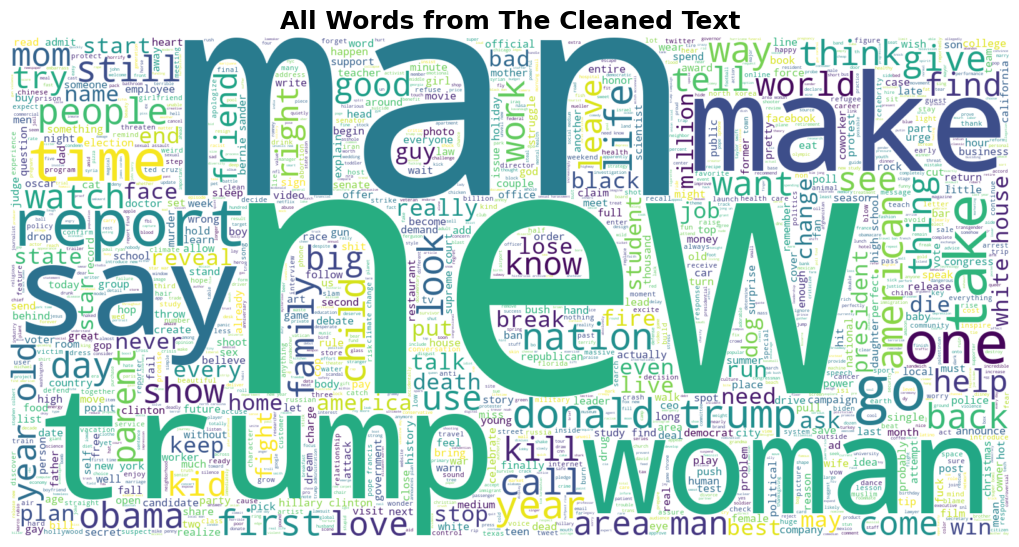

In [28]:
wc = WordCloud(width=1600, height=800,background_color="white", max_words=2000).generate(wc_string)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('All Words from The Cleaned Text', fontsize=18, fontweight = 'bold')
plt.show()

#### WordCloud for Non-Sarcastic Headlines

In [29]:
non_sarcastic = df[df.is_sarcastic == 0]['clean_headline'].str.cat(sep=' ')

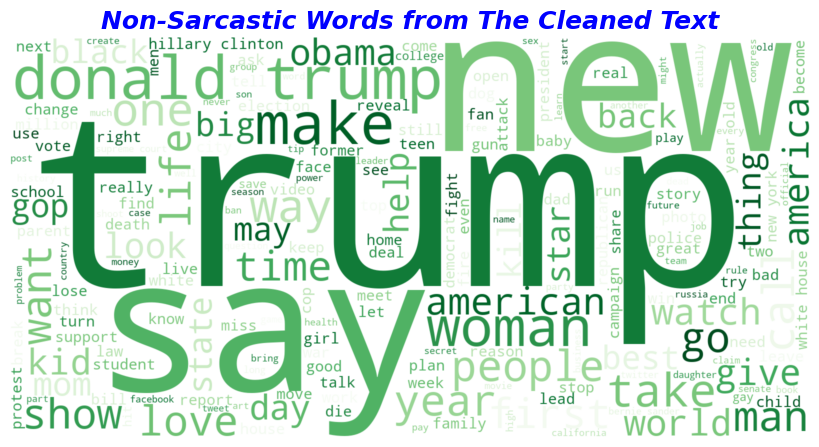

In [32]:
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Greens").generate(non_sarcastic)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Non-Sarcastic Words from The Cleaned Text', fontsize=18, fontstyle = 'italic', color = 'blue', fontweight = 'bold')
plt.show()

#### WordCloud for Sarcastic Headlines

In [33]:
sarcastic = df[df.is_sarcastic == 1]['clean_headline'].str.cat(sep=' ')

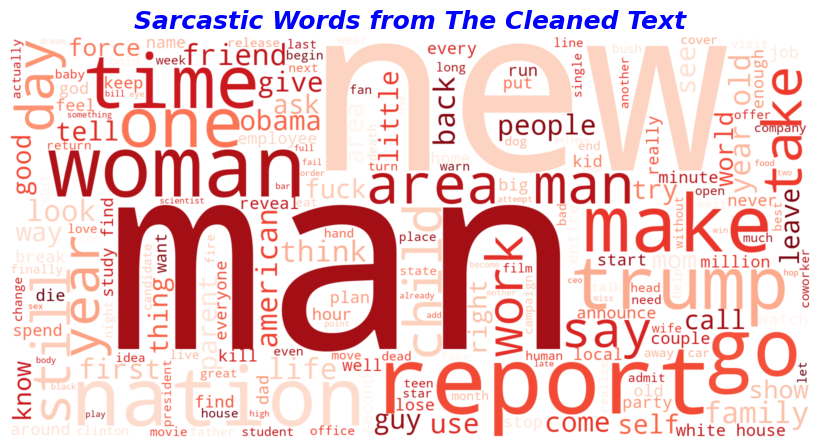

In [34]:
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Reds").generate(sarcastic)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Sarcastic Words from The Cleaned Text', fontsize=18, fontstyle = 'italic', color = 'blue', fontweight = 'bold')
plt.show()

## Feature Extraction

In [35]:
# Total number of words used

df['nb_words'] = df.headline.apply(lambda x:len(x.split()))

# Number of unique words

df['nb_unique_words'] = df.headline.apply(lambda x: len(set(x.split())))

# Total number of characters used

df['nb_char'] = df.headline.apply(lambda x:len(x))

# Total number of unique characters used

df['nb_unique_char'] = df.clean_headline.apply(lambda x:len(set(x.split())))

In [37]:
# Total number of punctuation used

import string

def num_punc(text):
  x =0
  for i in text.split():
     if i in list(string.punctuation):
       x = x+1 
  return x

df['nb_puctuation'] = df.headline.apply(lambda x: num_punc(x))

In [38]:
# Total number of stop words

import nltk, os, re
from nltk.corpus import stopwords
stopset = stopwords.words('english')

def num_stpwrds(text):
  x=0 
  for i in text.split():
    if i in stopset:
      x =x+1
  return x

df['nb_stpwrds'] = df.headline.apply(lambda x: num_stpwrds(x))

In [39]:
# Average length of words

import numpy as np

def length(text):
  return(np.mean([len(w) for w in text.split()]))

df['nb_len_wrd'] = df.headline.apply(lambda x:length(x))

In [40]:
#Number of most frequent words

tokens = nltk.word_tokenize(''.join(df.headline))
frequent = nltk.FreqDist(tokens)
frequent.most_common(15)

[('to', 8996),
 ('of', 6241),
 ("'s", 5058),
 ('in', 4430),
 ('the', 4353),
 (',', 3896),
 ('for', 3576),
 ("'", 3324),
 ('a', 2891),
 (':', 2650),
 ('on', 2544),
 ('and', 1978),
 ('with', 1922),
 ('is', 1654),
 ('at', 1297)]

In [41]:
#Removing stopwords and punctuation

stopword = stopwords.words('english')

for sym in string.punctuation:
    del frequent[sym]
    
for word in stopword:
    del frequent[word]
    
frequent.most_common(15)

[("'s", 5058),
 ('trump', 1234),
 ('new', 1185),
 ("n't", 1132),
 ('man', 866),
 ('one', 489),
 ('like', 416),
 ('says', 414),
 ('get', 409),
 ('first', 387),
 ('still', 363),
 ('people', 346),
 ('make', 342),
 ('could', 328),
 ('woman', 313)]

In [42]:
## NUMBER OF WORDS CONTAIN OUT OF MOST COMMON 100 WORDS 

freq_words = list(dict(frequent.most_common()[:100]).keys())

def freq(text):
    return(len([w for w in text.split() if w in freq_words]))
df['nb_freq_words'] = df.headline.apply(lambda x: freq(x))

In [43]:
# AVERAGE OF FREQ TERMS WITH TOTAL WORDS USED


def freq(text):
    return(len([w for w in text.split() if w in freq_words])/len(text.split()))
  
df['avg_freq_word'] = df.headline.apply(lambda x: freq(x))

In [44]:
df.describe()

is_sarcastic      nb_words  nb_unique_words       nb_char  \
count  28619.000000  28619.000000     28619.000000  28619.000000   
mean       0.476397     10.049967         9.913624     62.308571   
std        0.499451      3.388307         3.252229     20.726483   
min        0.000000      2.000000         1.000000      7.000000   
25%        0.000000      8.000000         8.000000     49.000000   
50%        0.000000     10.000000        10.000000     62.000000   
75%        1.000000     12.000000        12.000000     75.000000   
max        1.000000    151.000000       113.000000    926.000000   

       nb_unique_char  nb_puctuation    nb_stpwrds    nb_len_wrd  \
count    28619.000000   28619.000000  28619.000000  28619.000000   
mean         7.094937       0.006429      2.743807      5.391303   
std          2.421116       0.082508      1.805130      0.973804   
min          0.000000       0.000000      0.000000      2.333333   
25%          5.000000       0.000000      1.000000      4.727273   
50%          7.000000       0.000000      2.000000      5.300000   
75%          9.000000       0.000000      4.000000      6.000000   
max         96.000000       3.000000     45.000000     13.333333   

       nb_freq_words  avg_freq_word  
count   28619.000000   28619.000000  
mean        0.947063       0.091500  
std         1.028506       0.098200  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         1.000000       0.083333  
75%         1.000000       0.142857  
max         8.000000       1.000000

In [45]:
df.head(5)

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  \
0  https://www.theonion.com/thirtysomething-scien...   
1  https://www.huffingtonpost.com/entry/donna-edw...   
2  https://www.huffingtonpost.com/entry/eat-your-...   
3  https://local.theonion.com/inclement-weather-p...   
4  https://www.theonion.com/mother-comes-pretty-c...   

                                      clean_headline  nb_words  \
0  thirtysomething scientist unveil doomsday cloc...         8   
1  dem rep totally nails congress fall short gend...        13   
2            eat veggie deliciously different recipe         7   
3           inclement weather prevents liar get work         8   
4  mother come pretty close use word stream corre...         9   

   nb_unique_words  nb_char  nb_unique_char  nb_puctuation  nb_stpwrds  \
0                8       61               7              0           1   
1               13       79              10              0           3   
2                7       49               5              0           1   
3                8       52               6              0           2   
4                9       61               8              0           1   

   nb_len_wrd  nb_freq_words  avg_freq_word  
0    6.750000              0           0.00  
1    5.153846              0           0.00  
2    6.142857              0           0.00  
3    5.625000              2           0.25  
4    5.888889              0           0.00

##  Modeling

In [47]:
label_y = df.is_sarcastic

In [48]:
df_clean = df.drop('is_sarcastic',axis=1)

In [49]:
seed = 777
X_train, X_test, y_train, y_test = train_test_split(df_clean, label_y, test_size=0.3, random_state=seed)

In [50]:
print("X_train Shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train Shape: (20033, 12) y_train shape: (20033,)
X_test shape: (8586, 12) y_test shape: (8586,)


In [59]:
X_train.head()

headline  \
17329  sinatra, hope, reagan deadlocked in race to grave   
17744                            nature's trust (part 1)   
12825                god admits he never created gerbils   
13901  michael jackson deposed as king of pop in hitl...   
21680  republicans outraged over redtube censoring of...   

                                            article_link  \
17329  https://entertainment.theonion.com/sinatra-hop...   
17744  https://www.huffingtonpost.com/entry/natures-t...   
12825  https://www.theonion.com/god-admits-he-never-c...   
13901  https://entertainment.theonion.com/michael-jac...   
21680  https://politics.theonion.com/republicans-outr...   

                                          clean_headline  nb_words  \
17329          sinatra hope reagan deadlocked race grave         8   
17744                                  nature trust part         4   
12825                      god admit never create gerbil         6   
13901       michael jackson depose king pop hitless coup        10   
21680  republican outrage redtube censor conservative...         8   

       nb_unique_words  nb_char  nb_unique_char  nb_puctuation  nb_stpwrds  \
17329                8       49               6              0           2   
17744                4       23               3              0           0   
12825                6       35               5              0           1   
13901               10       54               7              0           3   
21680                8       66               6              0           2   

       nb_len_wrd  nb_freq_words  avg_freq_word  
17329       5.250              0       0.000000  
17744       5.000              0       0.000000  
12825       5.000              1       0.166667  
13901       4.500              0       0.000000  
21680       7.375              0       0.000000

### Dataset for Extracted Feature Model

In [51]:
df_1 = X_train.drop(['article_link','headline','clean_headline'],axis=1)
df_1.head()

nb_words  nb_unique_words  nb_char  nb_unique_char  nb_puctuation  \
17329         8                8       49               6              0   
17744         4                4       23               3              0   
12825         6                6       35               5              0   
13901        10               10       54               7              0   
21680         8                8       66               6              0   

       nb_stpwrds  nb_len_wrd  nb_freq_words  avg_freq_word  
17329           2       5.250              0       0.000000  
17744           0       5.000              0       0.000000  
12825           1       5.000              1       0.166667  
13901           3       4.500              0       0.000000  
21680           2       7.375              0       0.000000

### Model on Extracted Features

In [52]:
df_corr = df.drop(['article_link','headline','clean_headline'],axis=1)
df_corr = pd.DataFrame(df_corr)
corr = df_corr.corr()

In [53]:
corr

is_sarcastic  nb_words  nb_unique_words   nb_char  \
is_sarcastic         1.000000  0.072512         0.076254  0.139099   
nb_words             0.072512  1.000000         0.990785  0.911442   
nb_unique_words      0.076254  0.990785         1.000000  0.909765   
nb_char              0.139099  0.911442         0.909765  1.000000   
nb_unique_char       0.200187  0.806830         0.816897  0.884717   
nb_puctuation       -0.031084  0.032349         0.030588  0.011120   
nb_stpwrds          -0.096509  0.714844         0.694116  0.493732   
nb_len_wrd           0.154334 -0.280774        -0.269632  0.108271   
nb_freq_words        0.066782  0.358001         0.362622  0.262058   
avg_freq_word        0.050037  0.082615         0.086179  0.013141   

                 nb_unique_char  nb_puctuation  nb_stpwrds  nb_len_wrd  \
is_sarcastic           0.200187      -0.031084   -0.096509    0.154334   
nb_words               0.806830       0.032349    0.714844   -0.280774   
nb_unique_words        0.816897       0.030588    0.694116   -0.269632   
nb_char                0.884717       0.011120    0.493732    0.108271   
nb_unique_char         1.000000       0.011813    0.216786    0.088743   
nb_puctuation          0.011813       1.000000   -0.010290   -0.045050   
nb_stpwrds             0.216786      -0.010290    1.000000   -0.524432   
nb_len_wrd             0.088743      -0.045050   -0.524432    1.000000   
nb_freq_words          0.313416      -0.012460    0.208121   -0.233339   
avg_freq_word          0.097453      -0.019506    0.002219   -0.172962   

                 nb_freq_words  avg_freq_word  
is_sarcastic          0.066782       0.050037  
nb_words              0.358001       0.082615  
nb_unique_words       0.362622       0.086179  
nb_char               0.262058       0.013141  
nb_unique_char        0.313416       0.097453  
nb_puctuation        -0.012460      -0.019506  
nb_stpwrds            0.208121       0.002219  
nb_len_wrd           -0.233339      -0.172962  
nb_freq_words         1.000000       0.902782  
avg_freq_word         0.902782       1.000000

<Axes: >

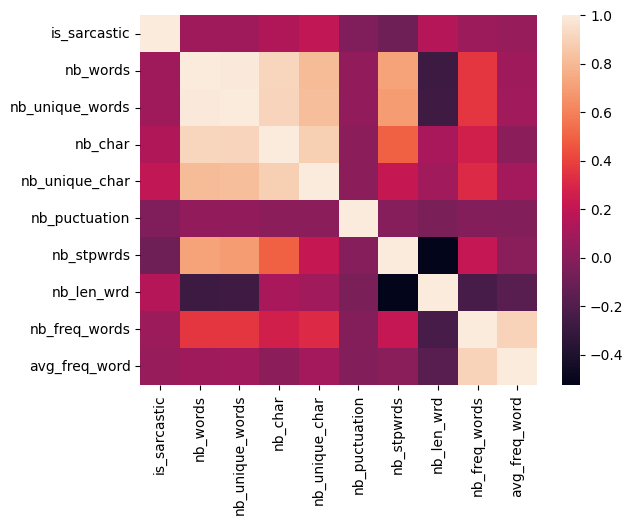

In [54]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Dataset on Text Features

In [87]:
df_2 = X_train.loc[:,'clean_headline']

print('Txt_Feature Dataset:',df_2.shape)
print('Txt_Feature Label:',y_train.shape)
df_2.head()

Txt_Feature Dataset: (20033,)
Txt_Feature Label: (20033,)


17329            sinatra hope reagan deadlocked race grave
17744                                    nature trust part
12825                        god admit never create gerbil
13901         michael jackson depose king pop hitless coup
21680    republican outrage redtube censor conservative...
Name: clean_headline, dtype: object

In [86]:
y_train.head()

17329    1
17744    0
12825    1
13901    1
21680    1
Name: is_sarcastic, dtype: int64

### MLFlow Initialisation

In [65]:
TRACKING_SERVER_HOST = "127.0.0.1"
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

### Modeling using MLFlow

In [67]:
EXPERIMENT_NAME = "vanilla-model-custom-clean-text"
mlflow.set_experiment(EXPERIMENT_NAME)

2024/08/19 15:11:20 INFO mlflow.tracking.fluent: Experiment with name 'vanilla-model-custom-clean-text' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlops-zc-sd-dev-model-registry/1', creation_time=1724080280958, experiment_id='1', last_update_time=1724080280958, lifecycle_stage='active', name='vanilla-model-custom-clean-text', tags={}>

In [91]:
# Vanilla Models
models = {
    'logistic_regression': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'xgboost': xgb.XGBClassifier(),
    'bernoulli_nb': BernoulliNB()
}

In [92]:
for model_name, model in models.items():
    with mlflow.start_run():
        mlflow.set_tag('developer', 'sushant')
        mlflow.set_tag('pipeline','pipe2_text')
        mlflow.set_tag('model', model_name)
        
        pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf',TfidfTransformer()),
            ('clf',model)
        ])
        
        # Cross-validation for accuracy, F1-score and ROC AUC
        accuracy_scores = cross_val_score(pipe, df_2, y_train, cv=10, scoring='accuracy')
        f1_scores = cross_val_score(pipe, df_2, y_train, cv=10, scoring='f1')
        roc_auc_scores = cross_val_score(pipe, df_2, y_train, cv=10, scoring='roc_auc')
        
        mlflow.log_metric('accuracy_mean', accuracy_scores.mean())
        mlflow.log_metric('accuracy_std', accuracy_scores.std())
        mlflow.log_metric('f1_mean', f1_scores.mean())
        mlflow.log_metric('f1_std', f1_scores.std())
        mlflow.log_metric('roc_auc_mean', roc_auc_scores.mean())
        mlflow.log_metric('roc_auc_std', roc_auc_scores.std())
        
        print(f'{model_name} Accuracy: {accuracy_scores.mean():.3f} +/- {accuracy_scores.std():.3f}')
        print(f'{model_name} F1-score: {f1_scores.mean():.3f} +/- {f1_scores.std():.3f}')
        print(f'{model_name} ROC AUC: {roc_auc_scores.mean():.3f} +/- {roc_auc_scores.std():.3f}')

2024/08/19 17:39:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run stylish-bear-129 at: http://127.0.0.1:5000/#/experiments/1/runs/88ed026e6cb84af98c9ea6b7013b99e6.
2024/08/19 17:39:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


logistic_regression Accuracy: 0.780 +/- 0.007
logistic_regression F1-score: 0.760 +/- 0.009
logistic_regression ROC AUC: 0.862 +/- 0.007


2024/08/19 17:56:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-deer-744 at: http://127.0.0.1:5000/#/experiments/1/runs/1b86d1812bf94445aec9f306cc0c4824.
2024/08/19 17:56:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


random_forest Accuracy: 0.753 +/- 0.006
random_forest F1-score: 0.716 +/- 0.008
random_forest ROC AUC: 0.833 +/- 0.008


2024/08/19 17:58:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-kite-721 at: http://127.0.0.1:5000/#/experiments/1/runs/3ecf3c0f1dee4957b1819664792a7b47.
2024/08/19 17:58:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


xgboost Accuracy: 0.720 +/- 0.008
xgboost F1-score: 0.651 +/- 0.011
xgboost ROC AUC: 0.800 +/- 0.007


2024/08/19 17:59:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run welcoming-owl-209 at: http://127.0.0.1:5000/#/experiments/1/runs/f434638e0ed64f618b46016b24c34698.
2024/08/19 17:59:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


bernoulli_nb Accuracy: 0.795 +/- 0.010
bernoulli_nb F1-score: 0.771 +/- 0.013
bernoulli_nb ROC AUC: 0.876 +/- 0.008


`Logistic Regression` and `Bernoulli Naive Bayes` give best results in terms of Accuracy, F1-score and ROC AUC score, so we will proceed with these two models for hyper parameter tuning to further better the performance of these models

### Hyperparameter Tuning of Vanilla Models

In [94]:
EXPERIMENT_NAME = "hyperparameter-tuning-sarcasm-detection"
mlflow.set_experiment(EXPERIMENT_NAME)

2024/08/19 18:09:36 INFO mlflow.tracking.fluent: Experiment with name 'hyperparameter-tuning-sarcasm-detection' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlops-zc-sd-dev-model-registry/2', creation_time=1724090976786, experiment_id='2', last_update_time=1724090976786, lifecycle_stage='active', name='hyperparameter-tuning-sarcasm-detection', tags={}>

In [101]:
params = {
    'logistic_regression': {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l2', 'l1'],
        'clf__solver': ['liblinear', 'saga'],  # Valid solvers for logistic regression with 'l1' penalty
        'clf__max_iter': [100, 200, 500]
    },
    'bernoulli_nb': {  # Correct hyperparameters for BernoulliNB
        'clf__alpha': [0.05, 0.1, 0.15, 0.20],
        'clf__binarize': [0.0, 0.1],  # This threshold is typically left at 0.0 for text data
        'clf__fit_prior': [True, False]  # Whether to learn class prior probabilities
    }
}

In [102]:
n_iter_search = 10

for model_name, param_grid in params.items():
    with mlflow.start_run():
        mlflow.set_tag('developer', 'sushant')
        mlflow.set_tag('pipeline','pipe2_text')
        mlflow.set_tag('model', model_name)
        
        pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf',TfidfTransformer()),
            ('clf', models[model_name])
        ])
        
        random_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=n_iter_search, cv=10, scoring='accuracy', random_state=42)
        random_search.fit(df_2, y_train)
        
        mlflow.log_params(random_search.best_params_)
        mlflow.log_metric('best_accuracy', random_search.best_score_)
        
        print(f'Model: {model_name}')
        print(f'Best Accuracy: {random_search.best_score_}')
        print(f'Best params: {random_search.best_params_}')


2024/08/19 18:29:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run upset-squid-744 at: http://127.0.0.1:5000/#/experiments/2/runs/02d0dc4573994abaab220312c694a3c7.
2024/08/19 18:29:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


Model: logistic_regression
Best Accuracy: 0.7605962563141316
Best params: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__max_iter': 100, 'clf__C': 10}


2024/08/19 18:29:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run adaptable-grouse-746 at: http://127.0.0.1:5000/#/experiments/2/runs/0071904ddaab440295d61a94f3623fde.
2024/08/19 18:29:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


Model: bernoulli_nb
Best Accuracy: 0.7869032030796121
Best params: {'clf__fit_prior': True, 'clf__binarize': 0.1, 'clf__alpha': 0.2}


The accuracy score for `Bernoulli Naive Bayes` is highest, hence this is selected for the final model.

## Predict on Test Set

In [103]:
df_2_test = X_test.loc[:,'clean_headline']
df_2_test.head()

1043        investigation fell nightstand postpone morning
25378    first minute chess game spend explain replacem...
14695                        high fat diet may screw brain
28448    government shutdown force national zoo turn pa...
13853                   rise walk fun fitness social trend
Name: clean_headline, dtype: object

In [104]:
y_test.head()

1043     1
25378    1
14695    0
28448    1
13853    0
Name: is_sarcastic, dtype: int64

In [107]:
final_params = {
    'fit_prior': True, 
    'binarize': 0.1, 
    'alpha': 0.2
}

In [108]:
final_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('clf', BernoulliNB(**final_params))
])

In [109]:
final_pipeline.fit(df_2, y_train)
y_pred = final_pipeline.predict(df_2_test)

In [110]:
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [111]:
final_results = confusion_matrix(y_test, y_pred) 
print("Confusion Matrix :")
print(final_results) 
print ("Accuracy Score :",accuracy_score(y_test, y_pred))
print ("Report : ")
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[3559  899]
 [1006 3122]]
Accuracy Score : 0.7781271837875612
Report : 
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4458
           1       0.78      0.76      0.77      4128

    accuracy                           0.78      8586
   macro avg       0.78      0.78      0.78      8586
weighted avg       0.78      0.78      0.78      8586



In [114]:
with mlflow.start_run(run_name='bernoulli-naive-bayes-model-0.1'):
    mlflow.log_params(final_params)
    mlflow.set_tag('developer', 'sushant')

    mlflow.set_tag('model', 'BernoulliNaiveBayes')
    mlflow.set_tag('status', 'final')

    mlflow.sklearn.log_model(final_pipeline, 'models')

2024/08/19 18:46:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/19 18:46:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run bernoulli-naive-bayes-model-0.1 at: http://127.0.0.1:5000/#/experiments/2/runs/8f2b597adc7248288391baaf186ae9a5.
2024/08/19 18:46:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


## Load the model from the S3 bucket

In [115]:
loaded_pipeline = mlflow.pyfunc.load_model('s3://mlops-zc-sd-dev-model-registry/2/8f2b597adc7248288391baaf186ae9a5/artifacts/models/')

/home/ec2-user/.local/share/virtualenvs/notebooks-ZFVeln3b/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [116]:
df_2_test.head()

1043        investigation fell nightstand postpone morning
25378    first minute chess game spend explain replacem...
14695                        high fat diet may screw brain
28448    government shutdown force national zoo turn pa...
13853                   rise walk fun fitness social trend
Name: clean_headline, dtype: object

In [117]:
y_test.head()

1043     1
25378    1
14695    0
28448    1
13853    0
Name: is_sarcastic, dtype: int64

In [120]:
loaded_pipeline.predict(df_2_test[:5])

array([1, 1, 0, 1, 0])